In [73]:
%matplotlib inline


NameError: name 'plotly' is not defined

In [74]:
import pandas as pd
import numpy as np
import re
import dateparser
from collections import defaultdict
from collections import Counter
import plotly as py
py.offline.init_notebook_mode(connected=True)

In [6]:
df = pd.read_csv("./data.csv")

In [7]:
df

,Numéro de dossier,Administration,Type,Année,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis
0,19840002,ministre de la défense,Avis,1984,03/03/1984,[Voir avis],"Justice, Ordre Public Et Sécurité/Défense Et D...",Armée,Défavorable/Défense,III,La commission d'accès aux documents administra...
1,19840003,ministre de la défense,Avis,1984,13/12/1984,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Armée,"Irrecevable/Imprécise, Défavorable/Défense, In...",III,La commission d'accès aux documents administra...
2,19850001,"ministre de l'économie, des finances et du budget",Avis,1985,05/12/1985,[Voir avis],"Justice, Ordre Public Et Sécurité/Association,...",NaN,Défavorable,III,La commission d'accès aux documents administra...
3,19860001,directeur départemental du travail et de l'emp...,Conseil,1986,30/01/1986,(voir avis),Travail Et Emploi/Droit Du Travail,"Licenciement, Conditions de travail","Défavorable/Procédure, Sans objet",III,La commission d'accès aux documents administra...
4,19870061,gouverneur de la Banque de France,Avis,1987,02/04/1987,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Banques et assurances,"Défavorable/Sécurité publique, Favorable/Sauf ...",III,La commission d'accès aux documents administra...
5,19870380,directeur de la caisse régionale d'assurance m...,Avis,1987,30/04/1987,[Voir avis],Affaires Sanitaires Et Sociales/Solidarités Et...,"Sécurité sociale, Conditions de travail",Défavorable/Secret,III,La commission d'accès aux documents administra...
6,19881774,directeur général des impôts,Avis,1988,24/11/1988,(voir avis),Finances Publiques Et Fiscalité/Contrôle Fisca...,NaN,Défavorable/Procédure,III,La commission d'accès aux documents administra...
7,19881993,ministre de l'intérieur,Avis,1988,22/12/1988,[Voir avis],"Justice, Ordre Public Et Sécurité/Sécurité Civ...",Politique et réglementation,"Défavorable/Abusive, Sans objet",III,La commission d'accès aux documents administra...
8,19890099,ministre de l'intérieur (direction de la logis...,Avis,1989,19/01/1989,"- instructions, circulaires et guides opérateu...","Justice, Ordre Public Et Sécurité/Sécurité Civ...",Politique et réglementation,Favorable,III,La commission d'accès aux documents administra...
9,19890845,ministre de la justice (direction de l'adminis...,Conseil,1989,18/05/1989,"- ""tableau de service"" du centre de détention ...","Travail Et Emploi/Emploi Public, Justice, Ordr...","Carrière, Lieux de détention",Défavorable/Sécurité publique,II,La commission d'accès aux documents administra...


In [25]:
df.Année = pd.to_numeric(df.Année)
df["Sens_reduced"] = df["Sens et motivation"].dropna().apply(lambda x: re.split("[/,]+", x)[0].strip())

In [145]:
def get_themes(text, target):
#     try:
    senses = re.split("[,]+", text)
    if target == "both_themes_subthemes":
        return list(set([s.strip() for s in senses]))
    if senses:
        splitted = map(lambda x: x.split("/"), senses)
        if target == "only_themes" and splitted:
            return list(set(map(lambda x: x[0].strip(), splitted)))
        elif target == "only_suousthemes" and splitted:
            motivations = list(map(lambda x: x[1].strip() if len(x) > 1 else "", splitted))
            return list(set([m.strip() for m in motivations if m]))
#     except:
#         return np.NaN

In [146]:
df["only_themes"] = df["Thème et sous thème"].dropna().apply(lambda x: get_themes(x, "only_themes"))
df["only_suousthemes"] = df["Thème et sous thème"].dropna().apply(lambda x: get_themes(x, "only_suousthemes"))
df["both_themes_sousthemes"] = df["Thème et sous thème"].dropna().apply(lambda x: get_themes(x, "both_themes_subthemes"))

In [187]:
all_themes_sousthemes_ll = np.hstack([df["only_themes"].dropna().values, df["only_suousthemes"].dropna().values])
all_themes_sousthemes = []
for ll in all_themes_sousthemes_ll:
    all_themes_sousthemes.extend([l.strip() for  l in ll if l])
all_themes_sousthemes = list(set(all_themes_sousthemes))
all_themes_sousthemes_d = dict(zip(all_themes_sousthemes, range(len(all_themes_sousthemes))))
all_themes_sousthemes_d

{'Economie': 0,
 'Sécurité Civile': 1,
 'Industrie': 2,
 'Assainissement': 3,
 'Sanction': 4,
 'Régulation Économique': 5,
 'Modalités': 6,
 'Contrôle Fiscal': 7,
 'Qualification': 8,
 'Données Personnelles': 9,
 'Finances Publiques': 10,
 "Autorisations Individuelles D'Urbanisme": 11,
 'Cadastre Et Hypothèques': 12,
 'Etrangers': 13,
 'Solidarités Et Prestations Sociales': 14,
 'Urbanisme': 15,
 'Agriculture': 16,
 'Provisoire': 17,
 'Culture': 18,
 'Risques Naturels Et Technologiques': 19,
 'Emploi Public': 20,
 'Santé Publique Et Questions Sanitaires': 21,
 'Finances Publiques Et Fiscalité': 22,
 'Loisirs': 23,
 'Enseignement': 24,
 'Archives': 25,
 'Transports': 26,
 'Politique Générale': 27,
 'Successions': 28,
 'Droit Du Travail': 29,
 'Étrangers': 30,
 'Environnement': 31,
 'Gestion De L’Impôt': 32,
 'Détention': 33,
 'Vie Locale': 34,
 'Commerce': 35,
 'Réutilisation Des Informations Publiques': 36,
 'Association': 37,
 'Développement Durable Et Transports': 38,
 'Défense Et Di

In [188]:
all_themes_sousthemes_ll

array([list(['Ordre Public Et Sécurité', 'Justice']),
       list(['Economie', 'Industrie', 'Ordre Public Et Sécurité', 'Environnement', 'Justice', 'Agriculture', 'Développement Durable Et Transports']),
       list(['Ordre Public Et Sécurité', 'Finances Publiques Et Fiscalité', 'Justice']),
       ..., list(['Emploi Public']), list(['Emploi Public']),
       list(["Autorisations Individuelles D'Urbanisme"])], dtype=object)

#### Get graph linking themes to subthemes

In [186]:
themes_with_subthemes = []
for v in df["both_themes_sousthemes"].dropna().values:
    for vv in v:
        if "/" in vv:
            themes_with_subthemes.append(vv)
themes_with_subthemes
for t in themes_with_subthemes:
    

['Ordre Public Et Sécurité/Défense Et Diplomatie',
 'Développement Durable Et Transports/Risques Naturels Et Technologiques',
 'Ordre Public Et Sécurité/Défense Et Diplomatie',
 'Agriculture/Secteurs Économiques',
 'Ordre Public Et Sécurité/Association',
 'Finances Publiques Et Fiscalité/Contrôle Fiscal',
 'Travail Et Emploi/Droit Du Travail',
 'Agriculture/Secteurs Économiques',
 'Travail Et Emploi/Droit Du Travail',
 'Affaires Sanitaires Et Sociales/Solidarités Et Prestations Sociales',
 'Finances Publiques Et Fiscalité/Contrôle Fiscal',
 'Ordre Public Et Sécurité/Sécurité Routière',
 'Ordre Public Et Sécurité/Sécurité Civile',
 'Ordre Public Et Sécurité/Sécurité Routière',
 'Ordre Public Et Sécurité/Sécurité Civile',
 'Ordre Public Et Sécurité/Détention',
 'Travail Et Emploi/Emploi Public',
 'Travail Et Emploi/Emploi Public',
 'Affaires Sanitaires Et Sociales/Santé Publique Et Questions Sanitaires',
 'Travail Et Emploi/Emploi Public',
 'Loisirs/Enseignement Scolaire',
 'Affaires San

In [9]:
def get_senses(text, target):
#     try:
    senses = re.split("[,]+", text)
    if target == "both_senses_motivs":
        return senses
    if senses:
        splitted = map(lambda x: x.split("/"), senses)
        if target == "only_senses" and splitted:
            return list(map(lambda x: x[0].strip(), splitted))
        elif target == "only_motivations" and splitted:
            motivations = list(map(lambda x: x[1].strip() if len(x) > 1 else "", splitted))
            return [m for m in motivations if m]
#     except:
#         return np.NaN

In [10]:
df["only_senses"] = df["Sens et motivation"].dropna().apply(lambda x: get_senses(x, "only_senses"))
df["only_motivations"] = df["Sens et motivation"].dropna().apply(lambda x: get_senses(x, "only_motivations"))
df["both_senses_motivs"] = df["Sens et motivation"].dropna().apply(lambda x: get_senses(x, "both_senses_motivs"))

In [11]:
df["both_senses_motivs"].iloc[1]


['Irrecevable/Imprécise',
 ' Défavorable/Défense',
 ' Incompétence/Renseignement']

In [12]:
tt = 1000
print(df["Sens et motivation"].iloc[tt])
get_senses(df["Sens et motivation"].iloc[tt], "only_senses")

Incompétence/Loi spéciale, Favorable


['Incompétence', 'Favorable']

## Stat Descriptive

Dans cette section, nous fournions des statistiques descriptives tirées à partir du jeux de données de la CADA (disponible sur https://www.data.gouv.fr/fr/datasets/avis-et-conseils-de-la-cada/). Spécifiquement, nous utilisons le jeu de données fourni par l'API de cada.gouv.fr, via http://cada.data.gouv.fr/export.

L'objectif de cet exercice est de decouvrir les grandes lignes de l'action au fils de temps, basées sur les donnees ouvertes que la CADA elle même depose sur data.gouv.fr. Nous nous interessons notamment à repondres des questioins concernant les frequences et les evolutions dans le temps des  administrations requetées par la CADA, les types des avis generés, les sens des avis, les motivations, entre autres.

Le fichier analysé contient 29306 lignes, c'est-à-dire, 29306 dossiers traites par la CADA, du 3 mars 1984 au 6 septembre 2018.

In [192]:
df.Séance_date.sort_values()

0       1984-03-03
1       1984-12-13
2       1985-12-05
3       1986-01-30
4       1987-04-02
5       1987-04-30
6       1988-11-24
7       1988-12-22
8       1989-01-19
9       1989-05-18
10      1990-02-08
11      1990-05-10
12      1990-05-23
13      1990-09-27
14      1990-11-22
15      1991-01-31
16      1991-02-28
17      1991-05-23
18      1991-05-23
19      1991-06-20
20      1991-12-19
21      1992-01-09
22      1992-02-20
23      1992-03-05
24      1992-03-19
26      1992-04-02
28      1992-04-30
27      1992-05-14
25      1992-05-27
29      1992-07-09
           ...    
29038   2018-09-06
29047   2018-09-06
29167   2018-09-06
29166   2018-09-06
29165   2018-09-06
29164   2018-09-06
29163   2018-09-06
29162   2018-09-06
29161   2018-09-06
29160   2018-09-06
29159   2018-09-06
29158   2018-09-06
29155   2018-09-06
29154   2018-09-06
29153   2018-09-06
29151   2018-09-06
29150   2018-09-06
29149   2018-09-06
29148   2018-09-06
29147   2018-09-06
29146   2018-09-06
29061   2018

### Distribution of the types of answers

Mais quels sont les types des actions realises par la CADA ? Alos, nous nous interessons à connaitre la repartition du type de dossiers traités par la CADA. 
Evidemment, le rôle le plus important de la CADA est de fournir des avis (27035), suivi de très loin par les requetes de conseils (2268) et les sanctions (3). 

Avis        27035
Conseil     2268 
Sanction    3    
Name: Type, dtype: int64


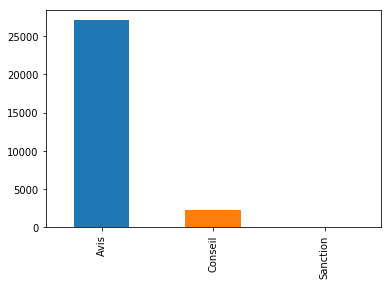

In [194]:
df.Type.value_counts().plot(kind="bar")
print(df.Type.value_counts())

### Distribution of the types of senses 
Parmi les avis fournis pour chaque dossier par la CADA, le plus grand nombre de sens donnée est nettement favorable. En suite, les demandes qui ne sont pas possibles d'êtres traitées par la CADA. Parmi les demandes refuses, en premier place nous trouvons le demandes sans objet. En deuxième place les avis défavorables, en troisième eux où la CADA s'estime incompétente et finalement les demandes irrecevables.

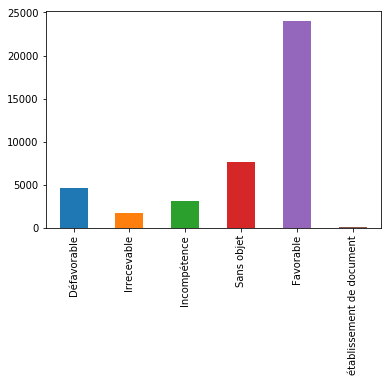

In [14]:
# Nasty way of doing this but it gets messy with get_dummies and co in Pandas
# do not know how to do it in a Pandas-ic way
dico_senses = defaultdict(int)
for v in df.only_senses.dropna().values:
    for vv in v:
        dico_senses[vv]+=1
del dico_senses[""]
foo = pd.Series(dico_senses).plot(kind="bar")


### Distribution of the types of motivations 
* TODO: Distribution of motivations ...

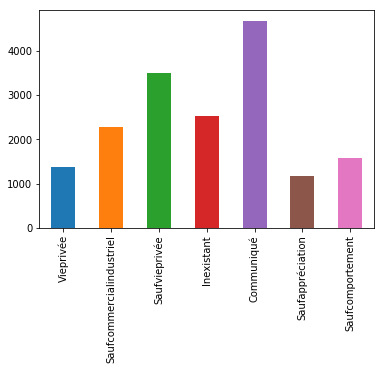

In [217]:
dico_motivations = defaultdict(int)
for v in df.only_motivations.dropna().values:
    for vv in v:
        new_key = re.sub(r"\s+", "", vv.strip())
        dico_motivations[new_key]+=1
# del dico_motivations[""]
# pd.DataFrame(dico_motivations, index=[0]).plot(kind="bar")
dico_motivations_filtered = dict(list(filter(lambda x: x[1] > 1000, dico_motivations.items())))
pd.Series(dico_motivations_filtered).plot(kind="bar")

### Distribution of Senses/Motivations coupled
Nous avons accès aussi à la motivation derrière la plus grande partie de sens. Pour les avis favorables, les motivations sont plutôt des remarques à prendre en compte lors de ce avis favorable.

Ci-dessous, nous regardons les couples sens / motivation les plus fréquentes (par souci de présentation, nous choisissons les couples avec une fréquence supérieur ou égal à 500). En effet, la couple sens / motivation plus importante est le Sans objet à cause d'un document demandé déjà communiqué par l'administration concernée. En deuxième place, la raison la plus importante pour avoir un avis sans objet est l'inexistence d'un document.

Dans l'autre cas, parmi les remarques pour les avis favorables, les deux les plus importantes sont ceux qui concernent les données de vie privée et commercial industriel.

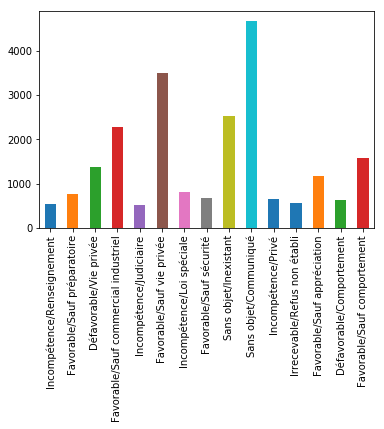

In [250]:
# df["both_senses_motivs"]
sens_motivs = defaultdict(int)
for v in df["both_senses_motivs"].dropna().values:
    for vv in v:
        new_key = vv

#         new_key = re.sub(r"\s\s+", " ", new_key)
        new_key = re.sub(r"\s/\s", "/", new_key)

#         new_key = re.sub(r"(\w)/(\w)", "\1 / \2 ", vv.strip())

        sens_motivs[new_key.strip().lstrip()] += 1
set(sens_motivs.keys())
sens_motivs_filtered = dict(list(filter(lambda x: x[1] >= 500 and "/" in x[0], sens_motivs.items())))
pd.Series(sens_motivs_filtered).plot(kind="bar")
# print(pd.Series(sens_motivs_filtered))

### Distribution des dossiers CADA par année
Voici la distribution des traitements de dossier par année. Nous pouvons regarder qu'à partir de l'année 2013, une explosion de traitements de dossiers (why?). En effet, nous passons de 771 en 2012 à 4779 en 2013. La tendance ne continuera plus est le traitement se stabilise avec le maximum en 2015.

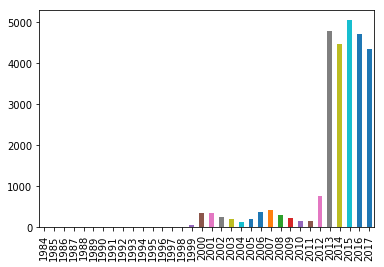

In [215]:
#df.Année.value_counts().plot(kind="bar")
df_b2018 = df[df.Année < 2018]
df_b2018.Année.value_counts().sort_index().plot(kind="bar")
# print(df_b2018.Année.value_counts().sort_index())

### All petitions per administration
* Most of them only receive one or two petitions from CADA
  

count    11086.000000
mean         2.643424
std         13.354510
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        972.000000
Name: Administration, dtype: float64


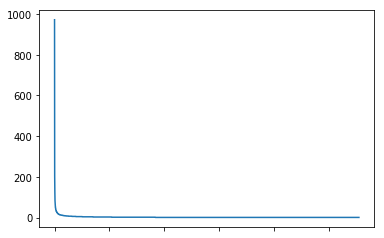

In [18]:
admin = df.Administration.dropna().value_counts()
admin.plot()
# Most administrations requested by the CADA receive only one or two petitions
print(admin.describe())

### Administrations with more than 50 CADA petitions
Those administrations that receive more than 50 petitions from CADA

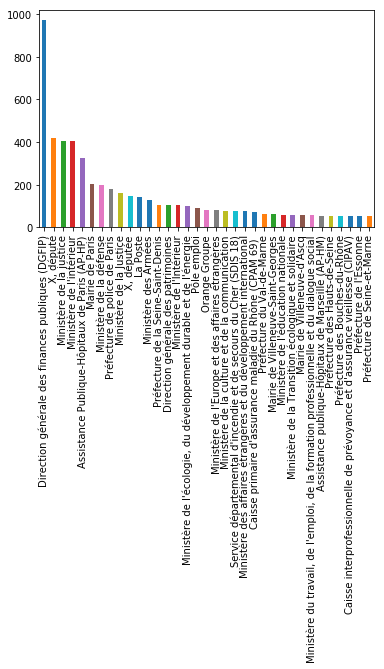

In [19]:
admin[admin >= 50].plot(kind="bar")
sup_50 = admin[admin >= 50].index

### Distribution of Senses per Year

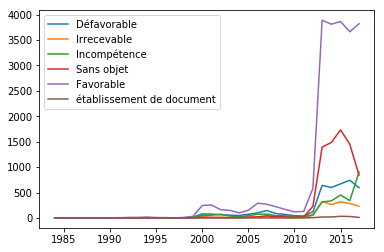

In [203]:
dico_annee_senses = defaultdict(lambda: defaultdict(int))
for year, senses in df_b2018[["Année", "only_senses"]].dropna().values:
    for s in [s for s in senses if s]:
        dico_annee_senses[year][s] += 1
dico_annee_senses_df = pd.DataFrame.from_dict(dico_annee_senses, orient="index").fillna(0)
dico_annee_senses_df.dropna().plot()


### Avereage Delay per Year

The intuition is that given that there are two dates on the first sentence of the Avis. The first one is the date of the
séance and the second one is the date of the reception of the dossier at the CADA. Usually, the first date is the same
as the one in the column séance. The second date is the date of the demande. So it should be as easy as substracting the latter from the former. 
 
But not all avis have two dates, a lot have only one and it can be either the date of the seance of the resolution or the date the demande was received. The date of the seance is intuitively always preceded by the phrase "dans sa seance du". So the other date should be always the date of the demande's reception.

In [47]:
# Split lines of the avis
df["Avis_splitted"] = df["Avis"].dropna().apply(lambda x: x.split("\n"))

In [48]:
def get_avis_regex(text):
    """
    Get the date of the reception of the avis. There are around 3000 avis that do not contain a reception date
    or are this naive approach is not able to extract said date (among ~40k, which is okish)
    """
    secretariat_regex = r"\sson secrétariat\sle\s([0-9][0-9]?\s\w{3,}\s[0-9]{,4})"
    par_lettre_regex = r"\slettre\sdu\s([0-9][0-9]?\s\w{3,}\s[0-9]{,4})"
    match = re.findall(par_lettre_regex, text[0])
    match2 = re.findall(secretariat_regex, text[0])
    if match or match2:
        return dateparser.parse(match[0] if match else match2[0], languages=["fr"])
    else:
        return None

In [49]:
# giant_regex = r'(séance\sdu\s[0-9][0-9]?\s\w+\s[0-9]{,4})|([0-9][0-9]?\s\w+\s[0-9]{4})'
df["Avis_splitted"] = df["Avis"].dropna().apply(lambda x: x.split("\n"))

df["Avis_dates"] = df.loc[df["Type"]=="Avis"]["Avis_splitted"].dropna().apply(lambda x: get_avis_regex(x))

In [50]:
#  Transform seance date
df["Séance_date"] = df["Séance"].dropna().apply(lambda x: dateparser.parse(x, languages=["fr"]))

In [51]:
delta_dates = (df.Séance_date - df.Avis_dates).apply(lambda x: x.days)

In [52]:
delta_dates[delta_dates < 0] = np.NaN
df["delta_dates"] = delta_dates

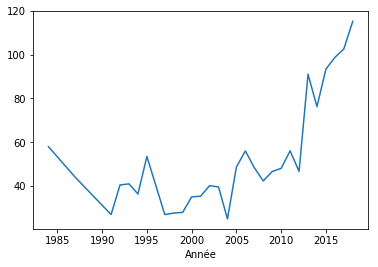

In [53]:
df.dropna().groupby(["Année", "delta_dates"], as_index=False).mean().groupby("Année")["delta_dates"].mean().plot()